In [1]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230703_data_c01'
dataname = data+'TesionMLP_time_comb'
filename = 'myLearningData/'+data+'.csv'
SD = pd.read_csv(filename)
SD=SD.iloc[:,:5]
SensorData = SD

In [2]:
SD

,Pre,Displacement,Tension,Resistance,Stutus
0,0.00,0.00,1.1,NaN,NaN
1,0.00,0.00,1.2,NaN,NaN
2,0.00,0.00,1.1,NaN,NaN
3,0.00,0.02,1.4,NaN,NaN
4,0.02,0.03,1.9,NaN,NaN
...,...,...,...,...,...
7764,0.00,0.00,1.7,71.95,0.0
7765,0.00,0.00,1.5,71.97,0.0
7766,0.00,0.00,1.5,71.98,0.0
7767,0.00,0.00,1.5,71.99,0.0


In [3]:
SD.describe()

,Pre,Displacement,Tension,Resistance,Stutus
count,7769.000000,7769.000000,7769.000000,6474.000000,3884.000000
mean,4.669009,4.669009,22.463792,41.612291,6.010427
std,3.304695,3.304695,13.163732,14.519180,3.605598
min,-0.010000,-0.010000,0.000000,16.030000,0.000000
25%,1.910000,1.910000,12.000000,30.012500,2.870000
50%,3.970000,3.970000,21.300000,40.015000,6.030000
75%,7.100000,7.100000,32.100000,52.007500,9.140000
max,12.010000,12.010000,53.400000,72.000000,12.010000


<Axes: >

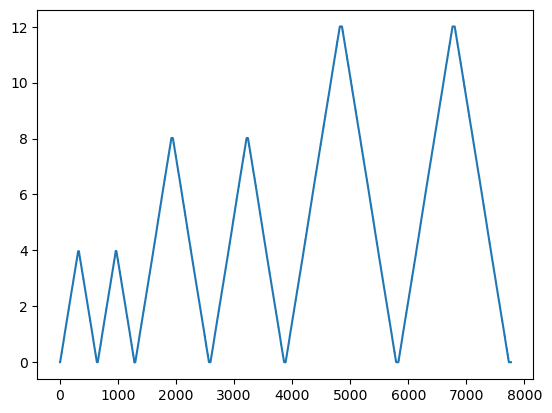

In [4]:
SDz=(SD.loc[:,'Displacement'])
SDz.plot()

In [5]:
SDy = SD.iloc[:,1]
SDy

0       0.00
1       0.00
2       0.00
3       0.02
4       0.03
        ... 
7764    0.00
7765    0.00
7766    0.00
7767    0.00
7768    0.00
Name: Displacement, Length: 7769, dtype: float64

In [6]:
X = SD.iloc[:,[0,1]]
y = SD.iloc[:,[2]]

In [7]:
X

,Pre,Displacement
0,0.00,0.00
1,0.00,0.00
2,0.00,0.00
3,0.00,0.02
4,0.02,0.03
...,...,...
7764,0.00,0.00
7765,0.00,0.00
7766,0.00,0.00
7767,0.00,0.00


In [8]:
y.sample(5)

,Tension
828,17.5
1477,17.8
7714,1.5
3104,33.8
6390,35.0


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.20, random_state=42)

In [10]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  6152 ea 79 %    X_valid:  1539 ea 19 %    X_test:  78 ea 1 %


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [12]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230703_data_c01TesionMLP_time_comb_SS.pkl']

In [13]:
from tensorflow import keras
model = keras.models.Sequential([    
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),   
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(1)
    
])

#model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum = 0.9,nesterov = True))
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho = 0.9))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


## Callback (best, early stopping, tensorboard)

In [15]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230630')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [16]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [17]:
dataname

'230703_data_c01TesionMLP_time_comb'

In [18]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 1
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
193/193 [==============================] - 2s 4ms/step - loss: 84.0151 - val_loss: 13.5134
Epoch 2/300
193/193 [==============================] - 1s 5ms/step - loss: 14.9137 - val_loss: 14.2644
Epoch 3/300
193/193 [==============================] - 1s 4ms/step - loss: 14.4739 - val_loss: 15.1242
Epoch 4/300
193/193 [==============================] - 1s 4ms/step - loss: 14.4290 - val_loss: 18.3258
Epoch 5/300
193/193 [==============================] - 1s 3ms/step - loss: 14.2005 - val_loss: 14.9338
Epoch 6/300
193/193 [==============================] - 1s 3ms/step - loss: 14.3067 - val_loss: 18.9466
Epoch 7/300
193/193 [==============================] - 1s 3ms/step - loss: 14.0859 - val_loss: 13.3294
Epoch 8/300
193/193 [==============================] - 1s 4ms/step - loss: 14.0704 - val_loss: 15.2427
Epoch 9/300
193/193 [==============================] - 1s 3ms/step - loss: 14.0226 - val_loss: 17.1246
Epoch 10/300
193/193 [==============================] - 1s 3ms/step - los

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./mylog/230630 --port=1630

In [19]:
model.save('H:/Jupyter_project/wearableActuator/myModel/'+dataname+'.h5')

In [20]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

49/49 [==============================] - 0s 1ms/step


In [21]:
X_valid

array([[-1.32638202, -1.33247103],
       [-1.28073318, -1.27769326],
       [ 1.81121436,  1.80812087],
       ...,
       [ 1.34863953,  1.34555307],
       [-1.11944064, -1.12248959],
       [-1.040316  , -1.04640936]])

In [22]:
valid_predictions

array([[ 3.1369715],
       [ 5.461561 ],
       [44.269344 ],
       ...,
       [36.897842 ],
       [ 7.806562 ],
       [ 8.004864 ]], dtype=float32)

In [23]:
X_test[0]

array([-0.93684532, -0.93381062])

In [24]:
arr = X_test
X_test0 = arr[:1]
X_test0

array([[-0.93684532, -0.93381062]])

In [25]:
valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_Tension"]
valid_predictions_df

,valid_Tension
0,3.136971
1,5.461561
2,44.269344
3,32.116089
4,34.544117
...,...
1534,14.159490
1535,0.881654
1536,36.897842
1537,7.806562


In [26]:
k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
k_df.columns  = ["Tension"]
k_df

,Tension
0,1.9
1,7.1
2,40.7
3,32.8
4,31.7
...,...
1534,16.5
1535,2.2
1536,32.7
1537,4.8


In [27]:
k_df.describe()

,Tension
count,1539.000000
mean,22.364198
std,13.305136
min,0.000000
25%,11.750000
50%,21.200000
75%,32.400000
max,53.400000


In [28]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
for i in range(0,1):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
98.30% Tension


,Tension,valid_Tension
Tension,1.000000,0.983017
valid_Tension,0.983017,1.000000


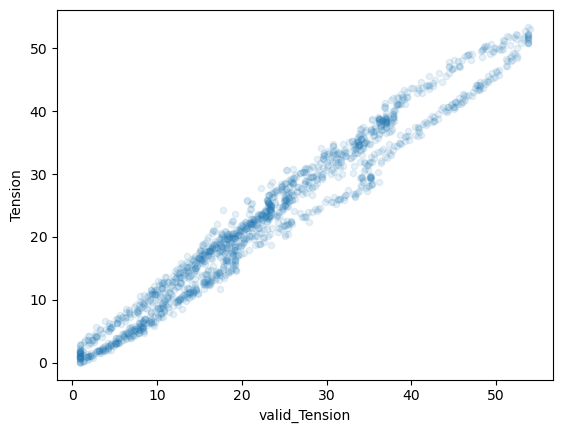

In [29]:
alpa=0.1

ValidPre.plot(kind="scatter", x= "valid_Tension",y= "Tension",alpha = alpa)
plt.savefig('H:/Jupyter_project/wearableActuator/savefig/'+dataname+'.png')
